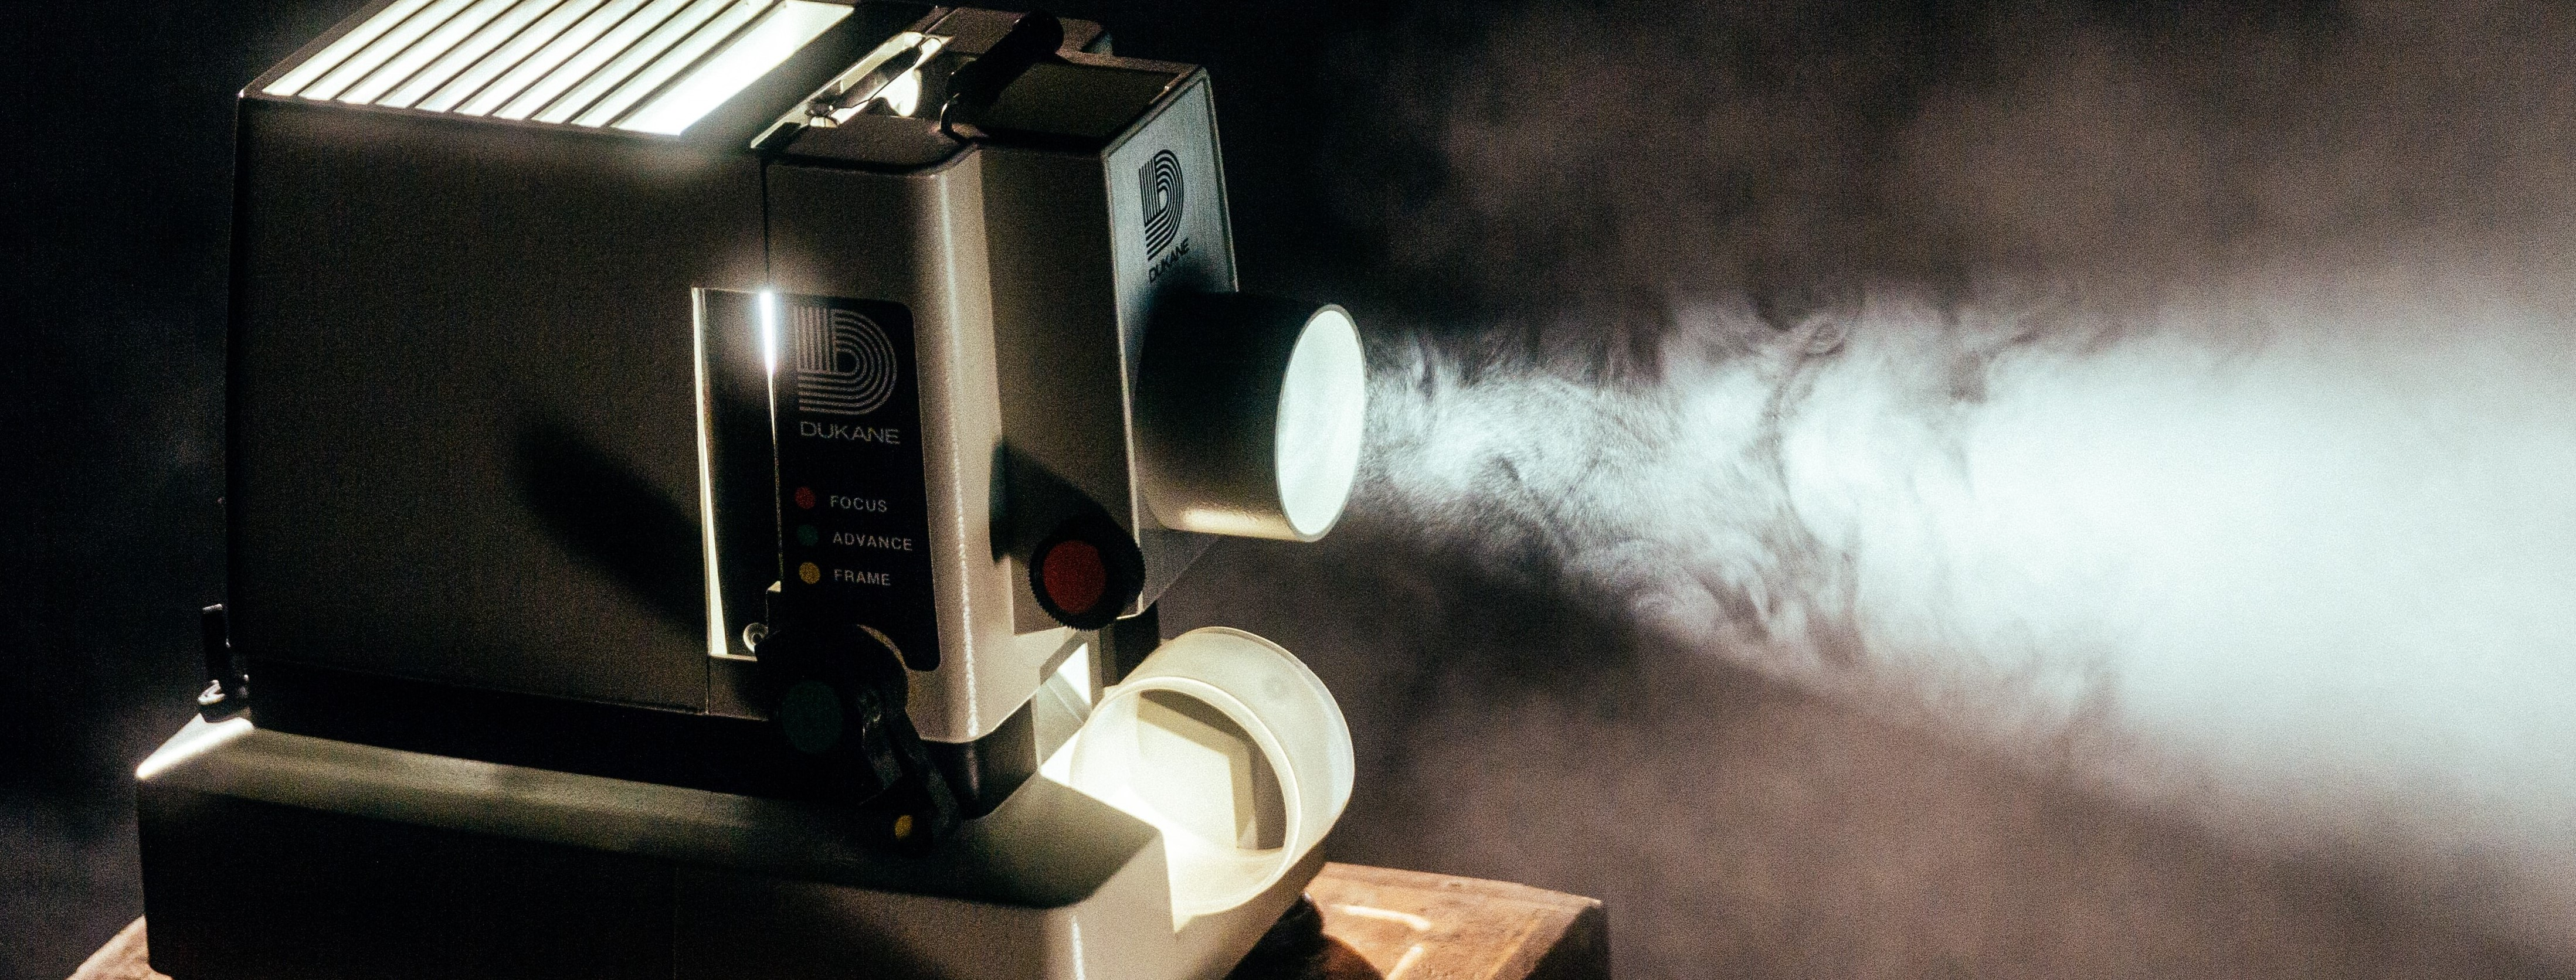

# Overview

This project analyses different movies in the movie industry to understand the most popular kind of movies and the factors that influence the success of a movie, in order to inform Microsoft's decision to start creating original video content. Descriptive analysis of movies' genres, length, reviews, and budget show the most popular genres to be documentaries, dramas and comedy. It also shows that length and genre have no effect on a movie's ratings. Furthermore, contrary to expectations, a large budget doesn't guarantee large returns. 


# Business Problem

Microsoft, a company mainly dealing in computer systems, is looking to start a movie production company that creates original content. 
Microsoft needs to understand the landscape of the movie industry by knowing which genres are most popular. This will enable it to cut down on some barriers to entry because it will already be creating something the audience responds to. 
Secondly, the company needs to understand how different factors, including length and genre, affect a movie's rating.
Lastly,Microsoft also needs to understand the financial aspect of movie production. Doing so will enable it to plan effectively. 

 # Data Understanding

The data sets used are from IMDB and The Numbers,both online databases containing information about different movies. 

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
movie_basics = pd.read_csv("zippedData/imdb.title.basics.csv",index_col=0)
movie_ratings = pd.read_csv("zippedData/imdb.title.ratings.csv",index_col=0)
movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv",index_col=0)

Movie_basics contains movie information from IMDB, including a movie's name, length,genre and publication year.

In [3]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146144 entries, tt0063540 to tt9916754
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    146144 non-null  object 
 1   original_title   146123 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.7+ MB


In [4]:
movie_basics.head(3)

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


Movie_ratings contains a movies average ratings from IMDB.

In [5]:
movie_ratings.head(3)

,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20


Movie_budgets contains infromation about a movie's budget and its domestic and worlwide gross. 

In [6]:
movie_budgets.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


# Data Preparation


For the movie_basics data set, I dropped the columns showing original title and year. I was only interested in the primary title,genre and runtime of the movie. 

There were no null values in the primary column, but there were duplicate entries. I dropped these since they would skew my analysis of popular genres.

There were null values in the genres column, which I also dropped.

The null values in runtime_minutes weren't a lot,so I chose to drop the outliers and because the distribution was not skewed, I filled the missing values with the mean. 

In [7]:
movie_basics.drop(labels=["original_title","start_year"],axis=1,inplace=True)

movie_basics.drop_duplicates(subset=["primary_title"],keep="first",inplace=True)

movie_basics.dropna(subset=["genres"],inplace=True)

# removing outliers
mean = movie_basics["runtime_minutes"].mean()
std = movie_basics["runtime_minutes"].std()
movie_basics = movie_basics.loc[movie_basics["runtime_minutes"] <= mean + (3 * std)]

# replacing null values in the runtime column
new_mean = movie_basics["runtime_minutes"].mean()
movie_basics.loc[:,"runtime_minutes"].fillna(new_mean)

tconst
tt0063540    175.0
tt0066787    114.0
tt0069049    122.0
tt0100275     80.0
tt0111414     75.0
             ...  
tt9915872     97.0
tt9916132     94.0
tt9916186     84.0
tt9916190     90.0
tt9916538    123.0
Name: runtime_minutes, Length: 104541, dtype: float64

For the movie_budgets dataset,I dropped the release date column since it wasn't of use to my analysis.

Several movie names were duplicated, so I dropped them because they would skew my analysis of profits made by individual movies. 

The columns containing financial information were stored as strings and contained different punctuations.I stripped the unwanted characters and changed the datatype. 

In [8]:
movie_budgets.drop(labels=["release_date"],axis=1,inplace=True)

movie_budgets.drop_duplicates(subset=["movie"],keep="first",inplace=True)

# removing unwanted characters in the columns
movie_budgets["production_budget"]=[i.translate(str.maketrans("","",string.punctuation)) \
                                       for i in movie_budgets["production_budget"]]

movie_budgets["domestic_gross"]=[i.translate(str.maketrans("","",string.punctuation)) \
                                       for i in movie_budgets["domestic_gross"]]

movie_budgets["worldwide_gross"]=[i.translate(str.maketrans("","",string.punctuation)) \
                                       for i in movie_budgets["worldwide_gross"]]

# changing the dtype of the columns
movie_budgets["production_budget"] = movie_budgets["production_budget"].astype(np.int64)
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].astype(np.int64)
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].astype(np.int64)

# Feature Engineering

I joined movie_basics with movie_ratings on the shared index in order to compare a movie's qualities and its ratings. 
I have also created a new column called dominant_genre that picks the first genre listed, with the assumption that it is the dominant genre.

In [9]:
# Merging movie_basics with movie_ratings 
movie_basics = movie_basics.merge(movie_ratings,left_index=True, right_index=True)

movie_basics["dominant_genre"] = [genre.split(",")[0] for genre in movie_basics["genres"]]
movie_basics

movie_budgets["estimated_profit"] = (movie_budgets["domestic_gross"] + movie_budgets \
                                        ["worldwide_gross"]) - movie_budgets["production_budget"]

For the movie_budgets dataset, I create a new column called estimated_profit that is a result of the sum of a  movie's domestic and worldwide budget, minus its production budget. It should be noted that it is an ESTIMATE of profit, with the assumtpion being that there are other costs that may not be included in the budget

In [10]:
movie_budgets["estimated_profit"] = (movie_budgets["domestic_gross"] + movie_budgets \
                                        ["worldwide_gross"]) - movie_budgets["production_budget"]

# Analysis

# Most common  movie genre

In [11]:
# Finding the most common genre
list_of_genres = movie_basics.loc[:,"genres"].str.split(",").to_list()

# flatten list of genres
list_of_genres_flat =[ i for genre in list_of_genres for i in genre ]
unique_genres = set(list_of_genres_flat)

# Build a frequency dictionary
frequency_dict = {}
for i in unique_genres:
    key = i
    value = 0
    frequency_dict.update({key:value})
    
for j in list_of_genres_flat:
    if j in frequency_dict.keys():
        frequency_dict[j] += 1

# Sort dict according to values
frequency_dict = sorted(frequency_dict.items(), key = lambda x: x[1])

The most common genres are documentaries, dramas and comedy. However, some movies are a combination of one or more genres and thus their popularity should be assessed based on an average of the individual popularities. 

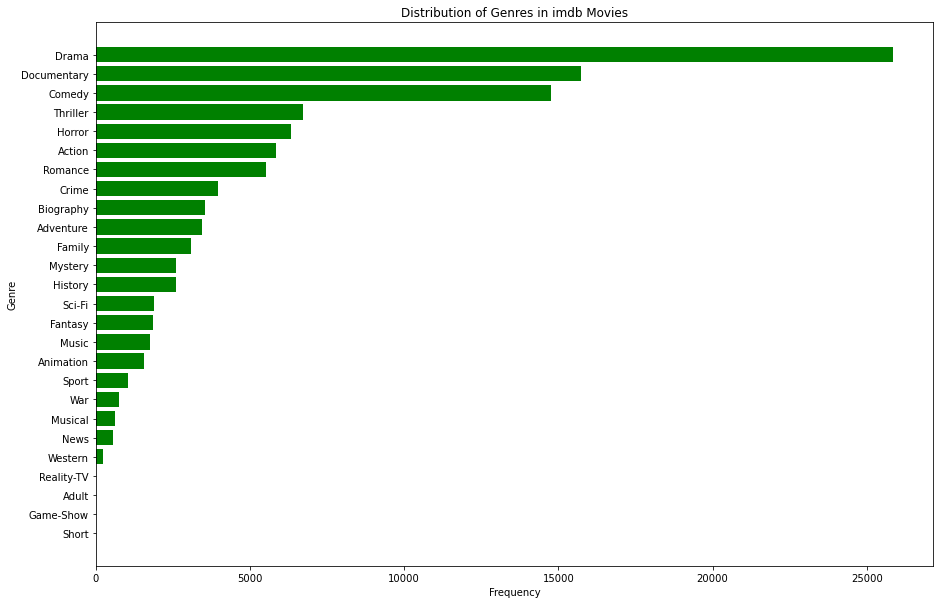

In [12]:
# Plotting frequency of genres
y_values = [i[1] for i in frequency_dict]
x_values =[i[0] for i in frequency_dict]

fig, ax = plt.subplots(figsize=(15,10))

ax.barh(x_values,y_values,color="green")


ax.set(title="Distribution of Genres in imdb Movies", ylabel="Genre", xlabel="Frequency");

# Relationship Between A Movie's Length and Its Ratings

There is no relationship between a movie's length and how good or bad it is rated. However, it can be seen that majority of movies run between 50 - 150 minutes

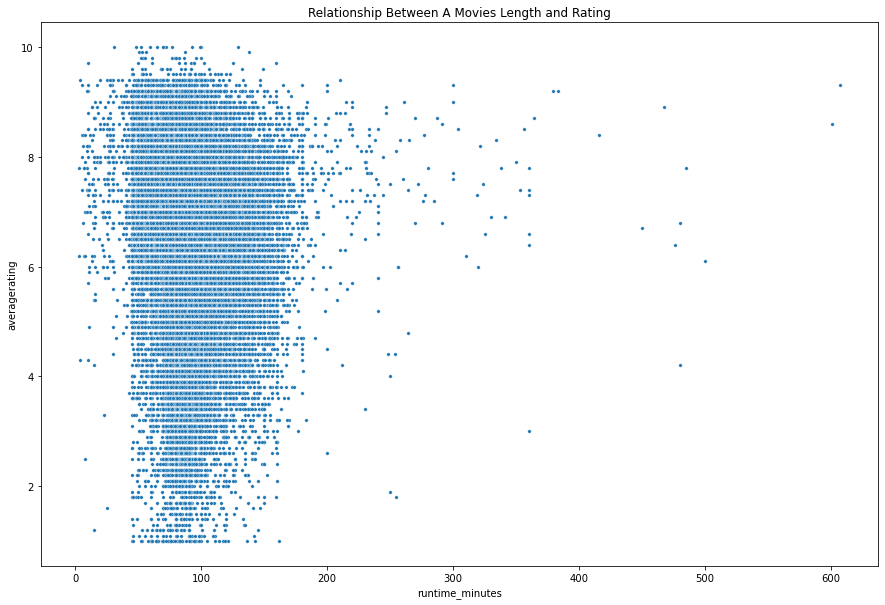

In [13]:

fig, ax = plt.subplots(figsize=(15,10))
scatterplot = sns.scatterplot(x = movie_basics["runtime_minutes"], \
                              y = movie_basics["averagerating"],s=12);
scatterplot.set(title = "Relationship Between A Movies Length and Rating");

# Relationship Between A Movie's Genre and Ratings?

While genre analysis took a count of each individual genre as it appeared, this analysis takes the first listed genre as the dominant genre.
I group the results according genres, and take a sample from the most and least popular genres. 
There is very slight difference between the worst and best ratings of genres in the popular categories and those in the less popular categories. Furthermore, the ratings of both the popular and less popular categories appear to be clustered around teh same values.

In [14]:
# finding ratings for top 3 and bottom 3 genres from analysis of distribution of genres above
group = movie_basics.groupby("dominant_genre")

# getting ratings from a sample of top genres
top_one = group.get_group("Drama").loc[:,["dominant_genre","averagerating"]]
top_two = group.get_group("Documentary").loc[:,["dominant_genre","averagerating"]]
top_three = group.get_group("Comedy").loc[:,["dominant_genre","averagerating"]]

# getting ratings from a sample of less popular genres
bottom_one = group.get_group("Reality-TV").loc[:,["dominant_genre","averagerating"]]
bottom_two = group.get_group("Western").loc[:,["dominant_genre","averagerating"]]
bottom_three = group.get_group("Musical").loc[:,["dominant_genre","averagerating"]]


rating_analysis = pd.concat([top_one,top_two,top_three,bottom_one,bottom_two,bottom_three],axis=0)


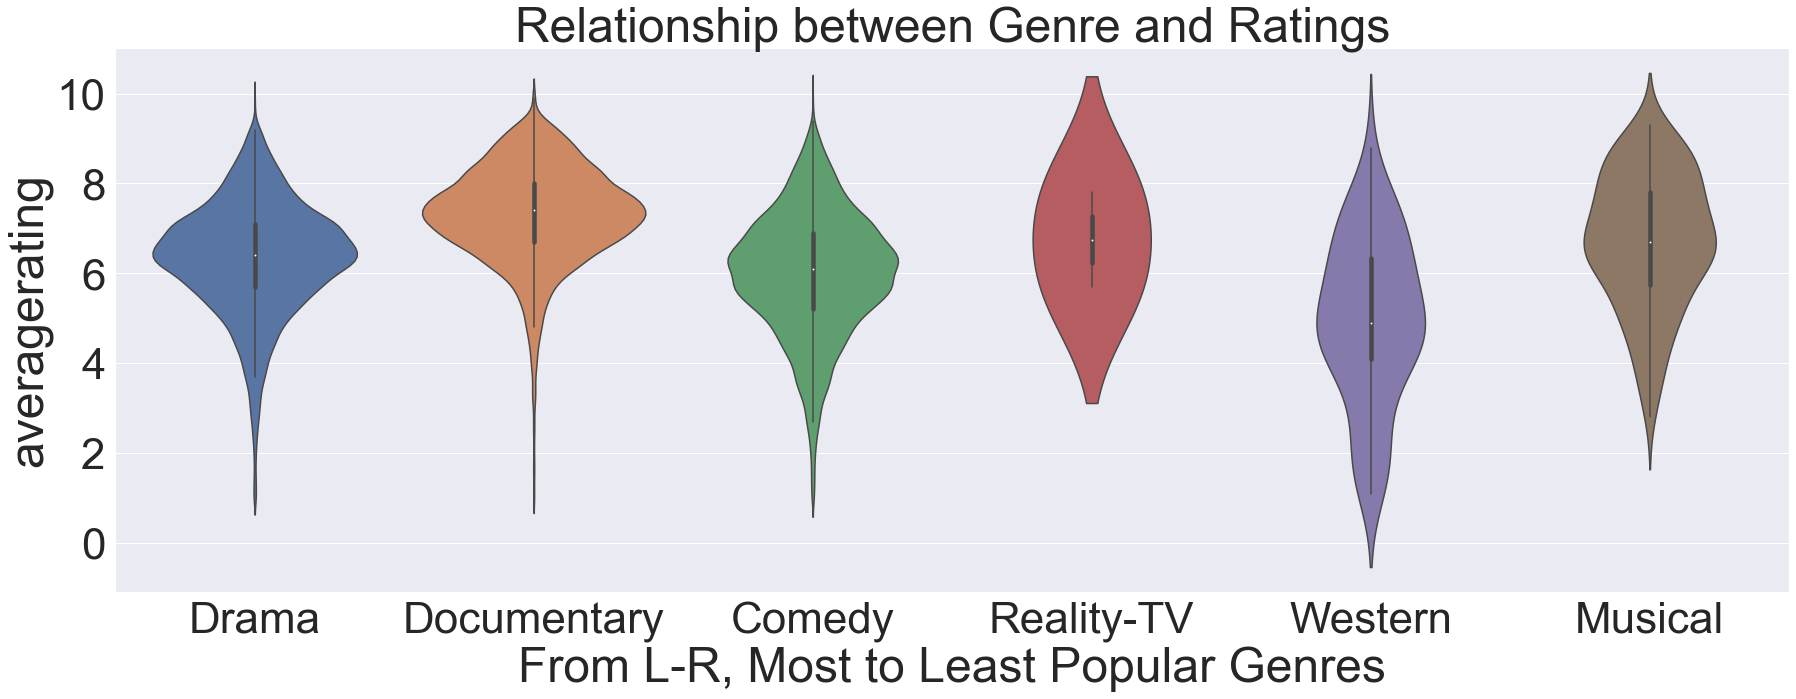

In [21]:
fig, ax = plt.subplots(figsize=(30,10))
sns.violinplot(x=rating_analysis["dominant_genre"], y=rating_analysis["averagerating"])

plt.title("Relationship between Genre and Ratings")
plt.xlabel("From L-R, Most to Least Popular Genres")
sns.set_context("poster");

# What is the relationship between budget and estimated profit?


Although domestic and worldwide earnings from a movie fall within a similar range, domestic gross is higher. There relationsip between a budget and estimated profit is weak.  

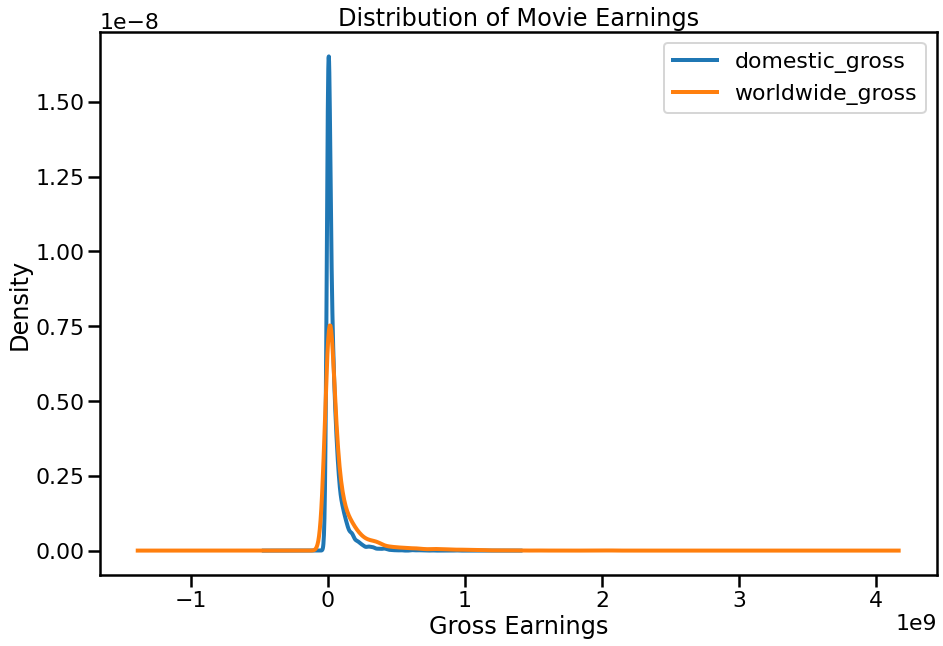

In [16]:
movie_budgets.loc[:,["domestic_gross","worldwide_gross"]].plot.density(figsize = (15, 10),
                                                                       linewidth = 4)

plt.title("Distribution of Movie Earnings")
plt.xlabel("Gross Earnings");

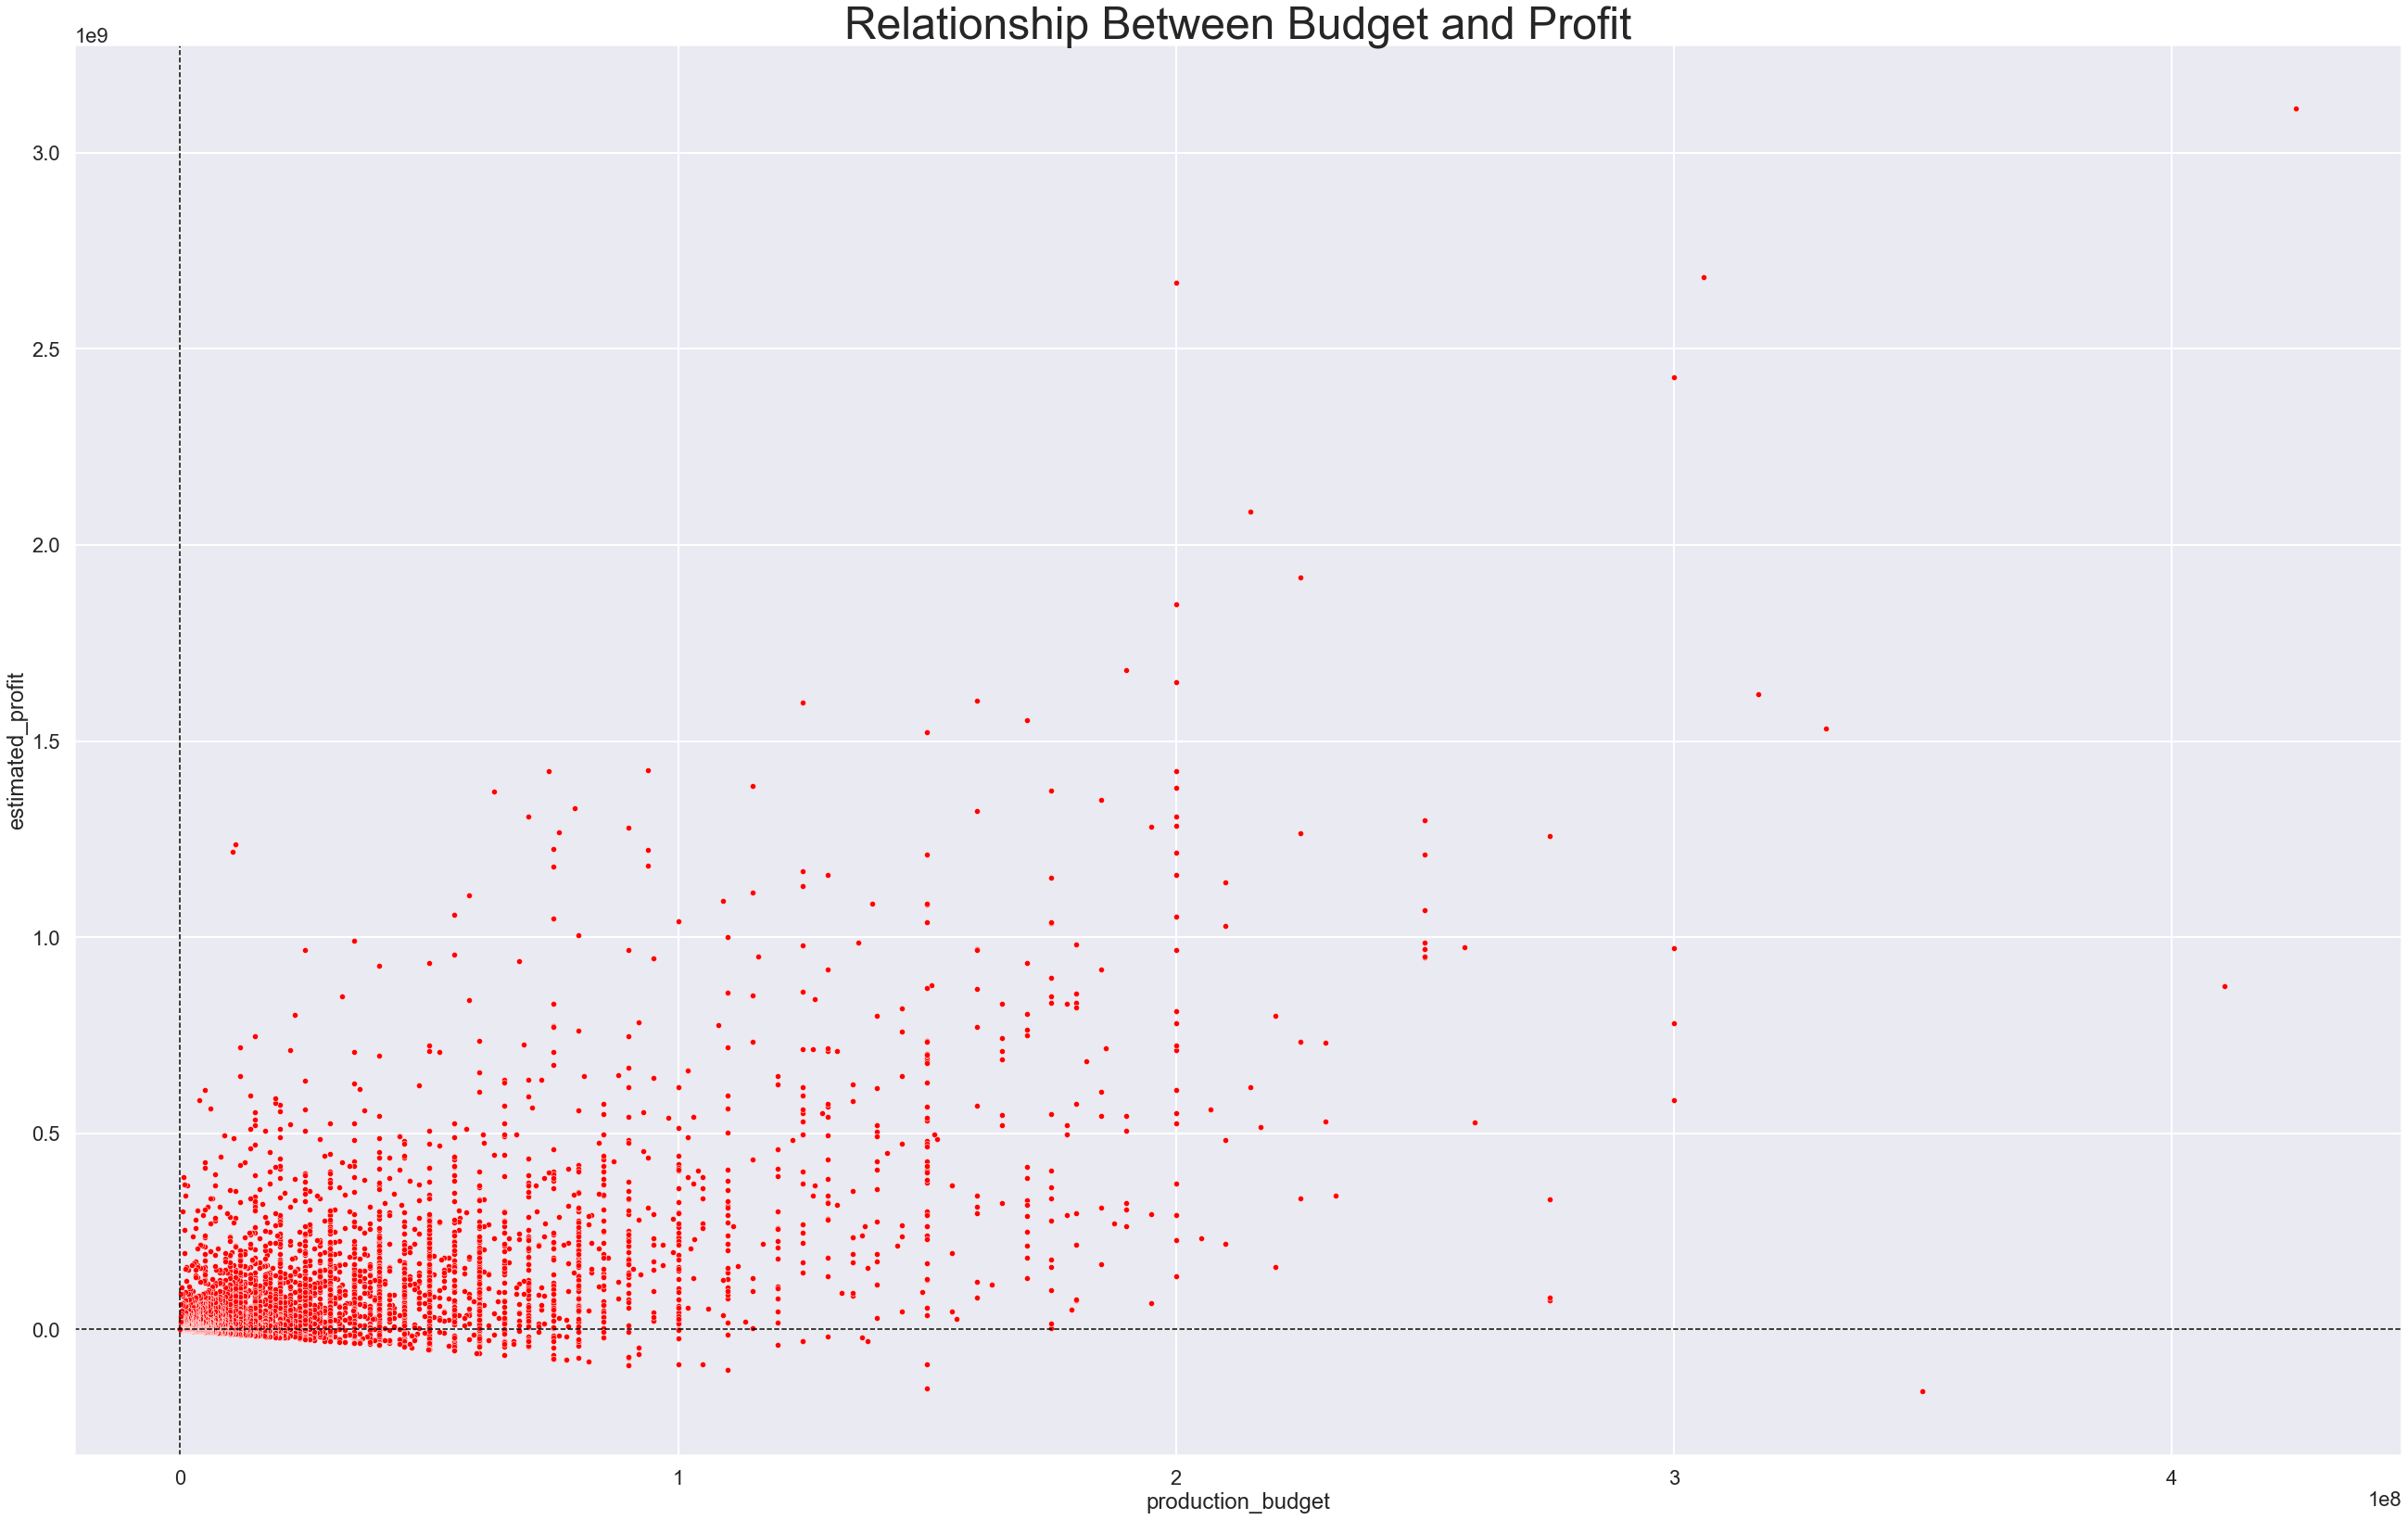

In [20]:

fig, ax = plt.subplots(figsize=(45,28))

sns.set(font_scale=1.0)
scatterplot = sns.scatterplot(data=movie_budgets,x="production_budget",y="estimated_profit",
                              color="red",s=38)
plt.axvline(0, c="black", ls="--")
plt.axhline(0, c="black", ls="--")

sns.set(font_scale=4.0)
scatterplot.set(title = "Relationship Between Budget and Profit");


# Conclusions

This analysis leades to three recommendations for Microsoft:

**Focus on the top genres, but a with a blend of different genres.** Focusing on the most popular genres will ensure receptiveness from the audience and potentially lower costs such as merketing because the audience already responds to tose genres. However, the company should also note that few movies have a stand-alone genre, and genre appears to have no effect on ratings. Success rate would be higher if a movie contains a mix of different genres. 

**Create movies whose length ranges between 50 and 200 minutes** Although a movie's length doesn't appear to affect its ratings, the industry standard for movies is around 100 minutes.

**Work with low-end and mid-level production budgets, with a focus on local sales before international sales.** Despite popular expectation, a high level budget does not guarantee more profit. Some movies show high budgets, but with losses. Starting with a low to mid budget will minimize financial risk.



# Next Steps

Further analysis can be done on:

**Factors that affect audience ratings of movies** This could be done through exploration of other datasets that have further information including critics vs audience ratings, and the standardized film rating system.

**NLP can be used to analyze movie reviews** This could help a company understand an audience's preferences beyond the numeric score given as a review. 

**Elements that constitute a movie's budget and expenditure** The datasets used had general information on budgets and costs. Datasets with more information, could create a better model for understanding the relationship between profits and budgets and what a company can do to maximize profits

